# A Simple Demonstation of basic F-Engine Checks

The `vla_f` Python library (https://github.com/realtimeradio/vla-dev/tree/master/software/control_sw)
provides a simple interface to F-Engine firmware, and can be used to check board state
and obtain antenna data at various stages in the DSP signal chain.
This notebook demonstrates some of the simplest, but most useful, tests.

Documentation of the library can be found at https://github.com/realtimeradio/vla-dev/blob/master/docs/cosmic-vlafpga.pdf

It is also useful to know the high-level architecture of the F-engine pipeline, which is shown below

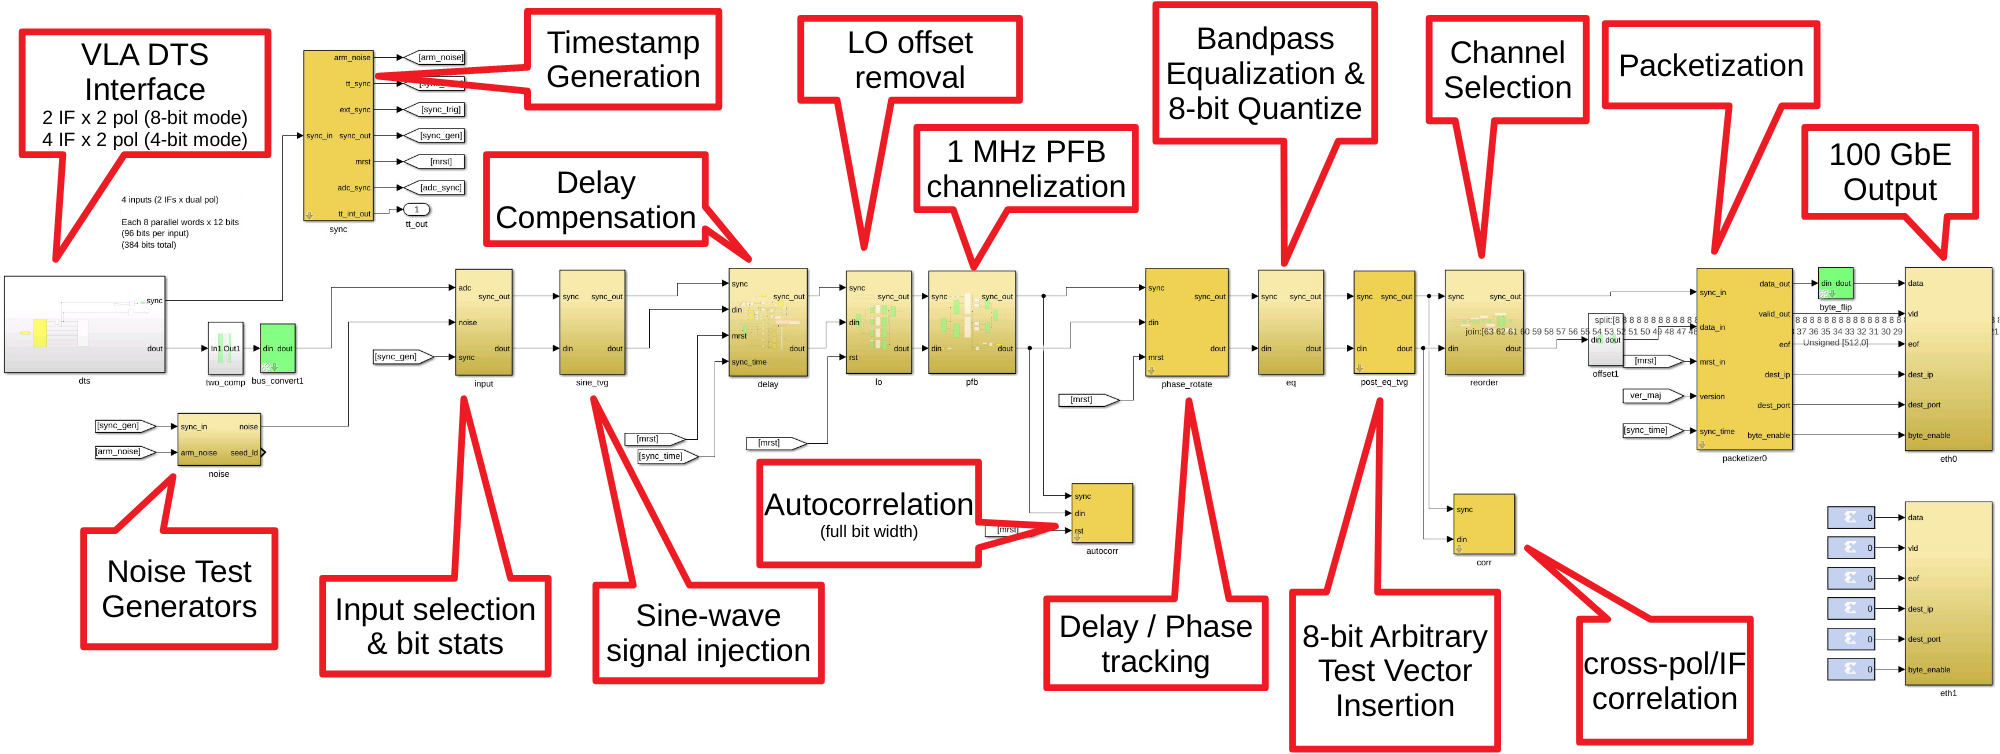

Each processing block in the pipeline has an associated API, allowing the block to be reconfigured and interrogated.

In [87]:
import numpy as np
from matplotlib import pyplot as plt
from cosmic.fengines import ant_remotefeng_map # Map antenna numbers to FPGA cards
from cosmic.hashpipe_aux import redis_obj # Redis interface

ANTENNA_NAME = 'ea11'

In [88]:
# First, create an interface to a running F-engine pipeline
# You can do this by antenna name
# But you'll need a connection to the site redis server
fengs = ant_remotefeng_map.get_antennaFengineDict(redis_obj, antname_filter=[ANTENNA_NAME])
feng = fengs[ANTENNA_NAME]

In [89]:
# The blocks in the diagram above can be accessed through Fengine attributes
# Eg. print basic FPGA status information
feng.fpga.print_status()

 - fw_build_time: 2022-05-19T18:14:37
 - fw_type: 2
 - fw_version: 13.2.2.0
 - host: cosmic-fpga-1:pcie3e
 - programmed: True
 - sw_version: 0.0.1-c26c0ef6
 - sys_mon: not reporting
 - timestamp: 2022-07-07T20:00:27.487826


In [90]:
# If your board is configured (because you are taking data) you shouldn't do this
# But if it hasn't been initialized outside of this notebook...
feng.initialize(read_only=False)
if feng.pipeline_id == 0:
    feng.dts.set_lane_map([0,1,3,2,4,5,7,6,8,9,11,10])
else:
    feng.dts.set_lane_map([4,5,7,6,0,1,3,2,8,9,11,10])
print(feng.dts.get_lane_ids())
feng.dts.align_lanes()
feng.sync.arm_sync()

Initializing block (writable): dts
Initializing block (writable): fpga
Initializing block (writable): sync
Initializing block (writable): delay
Initializing block (writable): lo
Initializing block (writable): noisegen
Initializing block (writable): sinegen
Initializing block (writable): input
Initializing block (writable): qsfp_a
Initializing block (writable): qsfp_b
Initializing block (writable): qsfp_c
Initializing block (writable): qsfp_d
Initializing block (writable): pfb
Initializing block (writable): autocorr
Initializing block (writable): eq
Initializing block (writable): eqtvg
Initializing block (writable): corr
Initializing block (writable): chanreorder
Initializing block (writable): eth0
Performing software global reset
pipeline0_dts - Setting lane map to [0, 1, 3, 2, 4, 5, 7, 6, 8, 9, 11, 10]
[11, 12, 11, 13, 12, 13, 12, 11, 13, 11, 13, 12]
pipeline0_dts - Reference: first sync at 16
pipeline0_dts - Reference: first post-sync at 17
pipeline0_dts - Reference: Second (referenc

In [91]:
feng.dts.print_status(ignore_ok=True) # Outputs nothing unless weirdness is occurring
if not feng.dts.is_synced():
    print('Uh oh... looks like the DTS link isn\'t properly locked')
is_3bit_mode = feng.dts.get_status()[0]['lane0:is3bit']
if is_3bit_mode:
    print('DTS is in 3-bit mode')
else:
    print('DTS is in 8-bit mode')

DTS is in 8-bit mode


In [92]:
# Or, print the mean, power, and RMS of the 8-bit digitizers.
# Here, and elsewhere in the code, IFs are numbered 0 though 3, and
# are intended to reflect 0=A, 1=C, 2=B, 3=D (i.e, 0,1 are a polarization pair, as are 2,3)
feng.input.print_status()

pipeline0_input - mean00: -1.7046394348144531
pipeline0_input - mean01: -3.014871597290039
pipeline0_input - mean02: -3.400360107421875
pipeline0_input - mean03: -0.8935146331787109
pipeline0_input - power00: 1033.98095703125
pipeline0_input - power01: 890.8900909423828
pipeline0_input - power02: 1044.1810913085938
pipeline0_input - power03: 1085.926284790039
pipeline0_input - rms00: 32.15557427618499
pipeline0_input - rms01: 29.84778201043392
pipeline0_input - rms02: 32.31379103894487
pipeline0_input - rms03: 32.95339564885596
pipeline0_input - switch_position00: adc
pipeline0_input - switch_position01: adc
pipeline0_input - switch_position02: adc
pipeline0_input - switch_position03: adc


In [93]:
# Find out what delays are currently loaded
feng.delay.print_status()

pipeline0_delay - delay00: 64
pipeline0_delay - delay01: 64
pipeline0_delay - delay02: 64
pipeline0_delay - delay03: 64
pipeline0_delay - max_delay: 524286
pipeline0_delay - min_delay: 64


In [94]:
# Or, set a delay on IF 0 to 100
feng.delay.set_delay(0,100)
feng.delay.force_load() # Usually a delay would only load on a nominated timestamp. Load immendiately!
feng.delay.print_status()

pipeline0_delay - Setting delay of stream 0 to 100
pipeline0_delay - delay00: 100
pipeline0_delay - delay01: 64
pipeline0_delay - delay02: 64
pipeline0_delay - delay03: 64
pipeline0_delay - max_delay: 524286
pipeline0_delay - min_delay: 64


pipeline0_input - Stream None: switching to ADC
Accumulation length is 131072 spectra
Accumulation length is 0.13 seconds
Number of IFs: 4
Number of chans: 1024


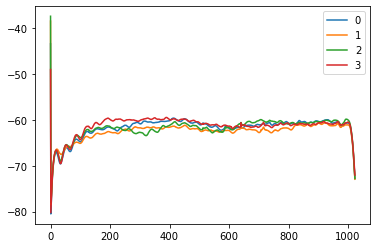

In [95]:
# The autocorrelation block allows you to plot the full bandpass of all IFs of an antenna.
# To capture test vectors...
#feng.input.use_noise()
# To capture real ADC data...
feng.input.use_adc()

#feng.autocorr.plot_all_spectra() # This doesn't work unless you are on the FPGA host, but we can do:
feng.autocorr.set_acc_len(128*1024)
acc_len = feng.autocorr.get_acc_len() # Accumulation length in spectra (1 spectra = 1usec)
print('Accumulation length is %d spectra' % acc_len)
print('Accumulation length is %.2f seconds' % (acc_len * 1e-6))
autocorrs = np.array(feng.autocorr.get_new_spectra())
n_if, n_chan = autocorrs.shape
print('Number of IFs: %d' % n_if)
print('Number of chans: %d' % n_chan)
for n in range(n_if):
    plt.plot(10*np.log10(autocorrs[n]), label=n)
plt.legend()
plt.show()
    